<a href="https://colab.research.google.com/github/AndreaBravo52/RedesNeuronales/blob/main/RedNeuronal_SerieDeTiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Predicción con Redes Neuronales

**Equipo:** Los Sonrientes Machine Learning Mavericks Cruzando el Rio en la Radio Número Uno

## Importación y limpieza de datos

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cd /content/drive/MyDrive/proyFinal-IDM

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/proyFinal-IDM/Datos CSV/reservaciones_diarias_revenue.csv", names=['Fecha','Día','num_reservas','Ingresos_pesos','Ingresos_dolares'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha             824 non-null    object 
 1   Día               824 non-null    object 
 2   num_reservas      824 non-null    int64  
 3   Ingresos_pesos    824 non-null    float64
 4   Ingresos_dolares  824 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 32.3+ KB


In [ ]:
df['Fecha']=pd.to_datetime(df['Fecha'])

In [ ]:
df.describe()

,Fecha,num_reservas,Ingresos_pesos,Ingresos_dolares
count,824,824.000000,8.240000e+02,824.0
mean,2020-02-17 12:00:00,246.361650,2.006886e+06,0.0
min,2019-01-02 00:00:00,1.000000,7.996000e+03,0.0
25%,2019-07-26 18:00:00,94.750000,7.514159e+05,0.0
50%,2020-02-17 12:00:00,177.000000,1.511317e+06,0.0
75%,2020-09-10 06:00:00,328.250000,2.644466e+06,0.0
max,2021-04-04 00:00:00,1728.000000,1.202485e+07,0.0
std,NaN,226.649429,1.795077e+06,0.0


In [ ]:
#ingresos en dolares esta vacia, se borra
df.drop(['Ingresos_dolares'], axis='columns', inplace=True)

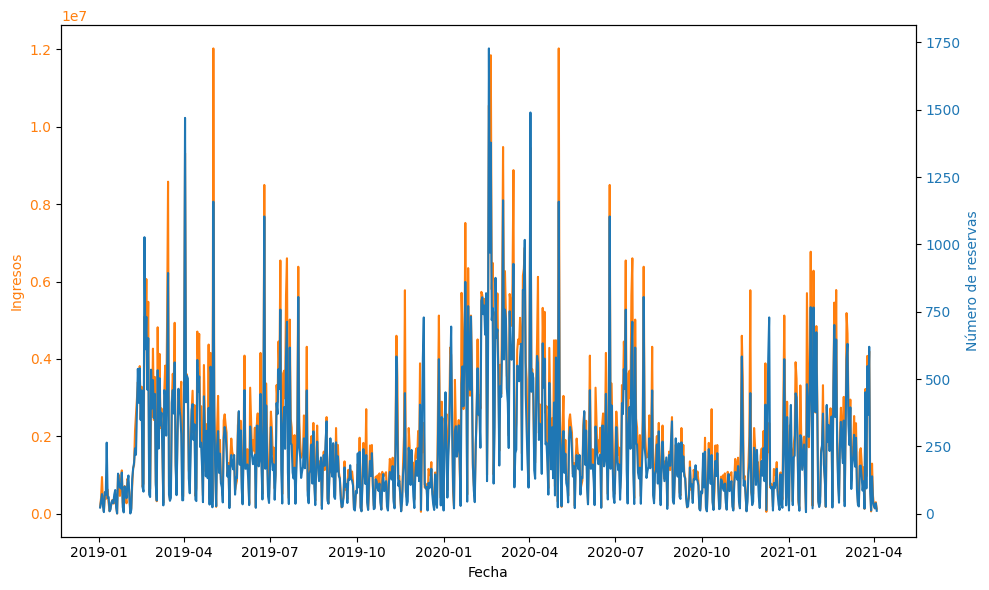

In [ ]:
#visualización de los datos
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:orange'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Ingresos', color=color)
ax1.plot(df['Fecha'], df['Ingresos_pesos'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Número de reservas', color=color)
ax2.plot(df['Fecha'], df['num_reservas'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
#Limpieza para solo pasar números a la red neuronal
df.drop(['Fecha'], axis='columns', inplace=True) #quitar fecha, el indice da el componente secuencial
df['Día'] = df['Día'].astype('category').cat.codes #convertir dia de la semana en categorico

In [ ]:
#normalizacion de datos
# Normalize the features and the target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Separate features and target
target = df[['Ingresos_pesos']]
features = df.drop(columns=['Ingresos_pesos'])


# Fit the scalers and transform the features and target
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Combine scaled features and target back into a DataFrame
data_scaled = pd.DataFrame(features_scaled, columns=features.columns)
data_scaled['Ingresos_pesos'] = target_scaled

## Creación de separación de datos para entrenamiento y pruebas

In [ ]:
data_scaled.info() #revisar que todos los datos que se meten a la red sean correctos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Día             824 non-null    float64
 1   num_reservas    824 non-null    float64
 2   Ingresos_pesos  824 non-null    float64
dtypes: float64(3)
memory usage: 19.4 KB


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
sequence_length = 10

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequence = data.iloc[i:i + sequence_length].values
        target = data.iloc[i + sequence_length]['Ingresos_pesos']
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)


#secuencias para todo el dataset
X, y = create_sequences(data_scaled, sequence_length)

# dividir en entrenamiento y prueba a 70/30
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

## Implementación y entrenamiento del modelo

In [ ]:
inputs = keras.Input(shape=(sequence_length, df.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(X_test, y_test)[1]:.2f}")

Epoch 1/10
18/18 [==============================] - 7s 98ms/step - loss: 0.0340 - mae: 0.1280 - val_loss: 0.0112 - val_mae: 0.0851
Epoch 2/10
18/18 [==============================] - 0s 27ms/step - loss: 0.0209 - mae: 0.1055 - val_loss: 0.0126 - val_mae: 0.0946
Epoch 3/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0205 - mae: 0.1036 - val_loss: 0.0128 - val_mae: 0.0961
Epoch 4/10
18/18 [==============================] - 0s 10ms/step - loss: 0.0196 - mae: 0.1014 - val_loss: 0.0112 - val_mae: 0.0854
Epoch 5/10
18/18 [==============================] - 0s 11ms/step - loss: 0.0196 - mae: 0.1005 - val_loss: 0.0098 - val_mae: 0.0723
Epoch 6/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0194 - mae: 0.0986 - val_loss: 0.0099 - val_mae: 0.0740
Epoch 7/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0194 - mae: 0.0976 - val_loss: 0.0104 - val_mae: 0.0790
Epoch 8/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0189 - mae:

## Evaluación del modelo

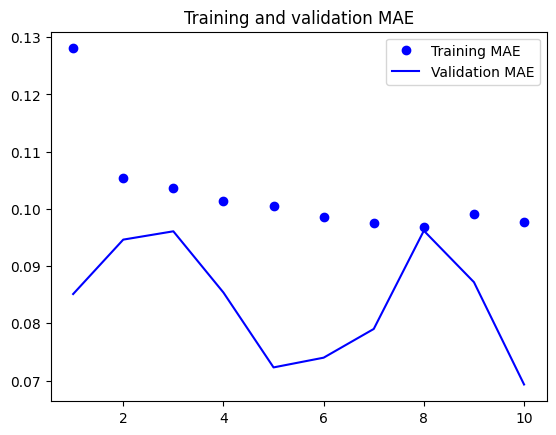

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 4ms/step - loss: 0.0097 - mae: 0.0693


[0.009662848897278309, 0.06930812448263168]